In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import cv2

# Display
from IPython.display import Image, display
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab.patches import cv2_imshow


In [19]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# Function


In [20]:
def processing_image(img_path):
    img = keras.utils.load_img(img_path, target_size=(299, 299))
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [21]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # inputs = tf.cast(image, tf.float32)
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(len(last_conv_layer_output))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
def plot_heatmap(img_path, heatmap):

    # 讀取影像
    img = cv2.imread(img_path)
    # Load the original image
    # img = keras.utils.load_img(img_path)
    # img = keras.utils.img_to_array(img)

    fig, ax = plt.subplots()
    # fig = plt.figure()
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # heatmap2 = cv2.resize(heatmap2, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    # heatmap2 = np.uint8(255 * heatmap2)
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)

    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    # cv2_imshow(img)
    plt.show()

# Run Model

In [23]:
# Prepare image
img_array = processing_image('/content/drive/MyDrive/cat_dog.png')

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
top_indices = np.argsort(preds)[0, ::-1][:5]

# print(decode_predictions(preds, top = 5)[0])
print("Predicted:", decode_predictions(preds, top=5)[0])
print(top_indices)

# Generate class activation heatmap
heatmap_cat = make_gradcam_heatmap(img_array, model, last_conv_layer_name, 282)
heatmap_dog = make_gradcam_heatmap(img_array, model, last_conv_layer_name, 243)

1/1 [==============================] - 1s 1s/step
Predicted: [('n02108422', 'bull_mastiff', 6.096671), ('n02123045', 'tabby', 4.818806), ('n02108089', 'boxer', 4.7240086), ('n02123159', 'tiger_cat', 4.6975937), ('n02124075', 'Egyptian_cat', 3.8044996)]
[243 281 242 282 285]


# Show Image

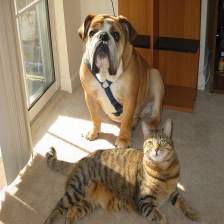

In [24]:
img = cv2.imread('/content/drive/MyDrive/cat_dog.png')
cv2_imshow(img)

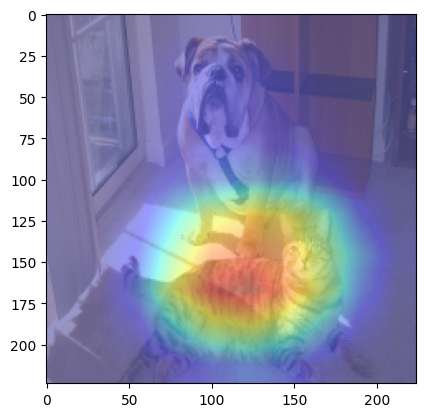

In [25]:
plot_heatmap('/content/drive/MyDrive/cat_dog.png', heatmap_cat)

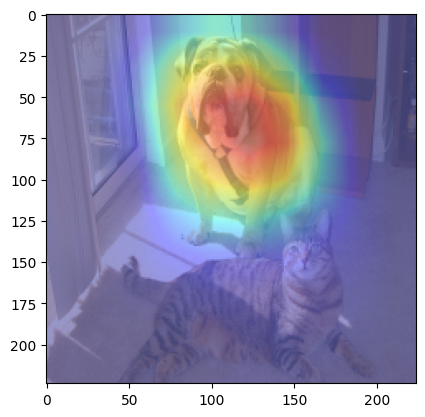

In [26]:
plot_heatmap('/content/drive/MyDrive/cat_dog.png', heatmap_dog)